In [147]:
# This file is currently outside the notebooks folder
%load_ext autoreload
%autoreload 2
import importlib.util
from pathlib import Path

import matplotlib.pyplot as plt
import rasterio
import torch
from rasterio.plot import show
from torchgeo.datasets import NAIP, BoundingBox

from data.kc import KaneCounty

# from data.dem import KaneDEM
from data.sampler import BalancedRandomBatchGeoSampler

config = importlib.import_module("configs.config")
MODEL_DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
# creating a preprocessor to convert the NAIP data to float
# and normalize
def preprocess(sample):
    """Converts image data to float

    Args:
        sample: a piece of a raster image
    Returns:
        sample image data in float
    """
    if "image" in sample:
        sample["image"] = sample["image"].float() / 255.0
        return sample
    sample["mask"] = sample["mask"].float() / 255.0
    return sample

In [149]:
# creaating and combining naip and kc shape data
naip = NAIP(config.KC_IMAGE_ROOT, transforms=preprocess)
print(naip.crs)
shape_path = str(Path(config.KC_SHAPE_ROOT) / Path(config.KC_SHAPE_FILENAME))
dataset_config = (
    config.KC_LAYER,
    config.KC_LABELS,
    config.PATCH_SIZE,
    naip.crs,
    naip.res,
)
kc = KaneCounty(shape_path, dataset_config)
print(kc.crs)

dataset = naip & kc
# dataset.crs=dem.crs
sampler = BalancedRandomBatchGeoSampler(
    config={
        "dataset": dataset,
        "size": config.PATCH_SIZE,
        "batch_size": config.BATCH_SIZE,
        "CRS": dataset.crs,
    }
)

EPSG:26916
EPSG:26916


In [150]:
# attempt to create a new class for the DEM dataset
from torchgeo.datasets import RasterDataset


class KaneDEM(RasterDataset):
    """A dataset class for handling Kane County Digital Elevation Model (DEM) data.

    Attributes:
        filename_glob (str): A string representing the pattern
        for matching DEM file names.
    """

    filename_glob = "Kane2017BE.tif"

    def __init__(self, paths, crs=None, res=None, transforms=None):
        """Initializes a KaneDEM instance.

        Args:
            paths (str or List[str]): Path(s) to the DEM data.
            crs (Optional[str]): Coordinate reference system (CRS) of the DEM data.
            res (Optional[float]): Spatial resolution of the DEM data.
            transforms (Optional[callable]): function/transform to apply to DEM data.

        Returns:
            None
        """
        super().__init__(paths, crs, res, transforms=transforms)
        self.all_bands = ["elevation"]  # Assuming single band for elevation

    def __getitem__(self, query: BoundingBox):
        """Retrieves a specific DEM sample from the dataset.

        Args:
            query: An index or query to retrieve the DEM sample.

        Returns:
            dict: A dictionary containing the elevation data.
        """
        # This method loads the DEM data similar to how other raster data is loaded
        sample = dict.fromkeys(["image"])
        with rasterio.open(str(config.KC_DEM_ROOT) / Path(self.filename_glob)) as src:
            bbox = (query.minx, query.miny, query.maxx, query.maxy)
            bbox = rasterio.warp.transform_bounds(self.crs, src.crs, *bbox)
            window = src.window(*bbox)
            sample["image"] = src.read(window=window)
        sample["image"] = torch.from_numpy(sample["image"])
        return sample

    def __getallbands__(self):
        """Get all bands for this dataset."""
        return self.all_bands

In [151]:
dem = KaneDEM(str(config.KC_DEM_ROOT), crs=naip.crs, res=naip.res)

In [152]:
# taking a sample bounding box
item = next(iter(sampler))

In [153]:
# printing out the CRS
dataset.crs

CRS.from_epsg(26916)

In [154]:
item[0]

BoundingBox(minx=391899.0661524276, maxx=392052.66615242756, miny=4661326.9390014345, maxy=4661480.539001434, mint=1630818000.0, maxt=1630904399.999999)

In [155]:
# checking dimensions of the DEM sample
dem[item[0]]["image"].shape

torch.Size([1, 256, 256])

In [156]:
# checking dmensions of the NAIP sample
naip[item[0]]["image"].shape

torch.Size([4, 256, 256])

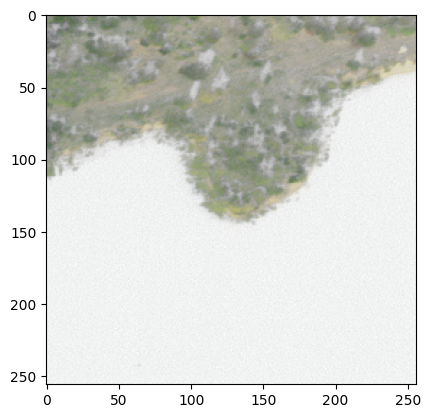

In [157]:
# plotting naip image
image = dataset[item[1]]["image"]
image = image.permute(1, 2, 0)

plt.imshow(image)
plt.show()

In [158]:
# creating a tuple out of the bounding box
item_bounds = (item[1].minx, item[1].miny, item[1].maxx, item[1].maxy)

(937088.4363320908, 1883230.7840704746, 937600.2294994432, 1883742.5772378256)
(256, 256)


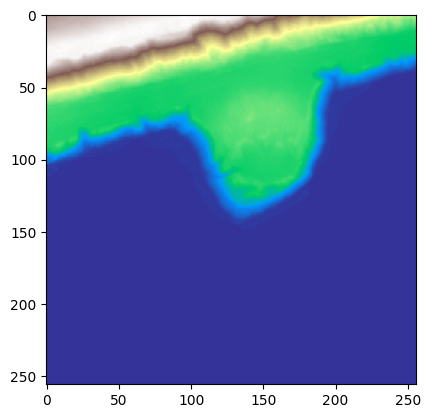

In [159]:
# converting DEM CRS to NAIP CRS and plotting the corresponding DEM image
with rasterio.open(str(config.KC_DEM_ROOT / Path("Kane2017BE.tif"))) as src:
    bbox = (item[1].minx, item[1].miny, item[1].maxx, item[1].maxy)
    bbox = rasterio.warp.transform_bounds(dataset.crs, src.crs, *bbox)
    window = src.window(*bbox)
    print(bbox)
    subset = src.read(1, window=window)
    print(subset.shape)
    show(subset, cmap="terrain")

In [160]:
# checking the CRS of the DEM object
dem.crs

CRS.from_epsg(26916)

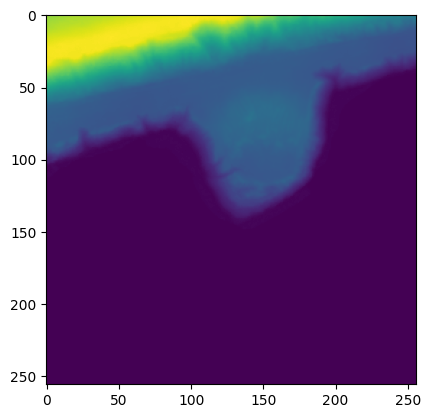

In [161]:
# plotting naip image
image = dem[item[1]]["image"]
image = image.permute(1, 2, 0)
plt.imshow(image)
plt.show()

In [162]:
dem.separate_files

False

In [163]:
dem[item[1]]

{'image': tensor([[[801.8954, 802.0288, 802.1298,  ..., 774.4644, 773.7612, 773.4183],
          [801.9875, 802.2095, 802.2488,  ..., 773.0481, 773.4012, 772.9215],
          [802.2043, 802.3782, 802.3679,  ..., 771.8643, 772.9965, 772.9303],
          ...,
          [745.6899, 745.6899, 745.6899,  ..., 745.6899, 745.6899, 745.6899],
          [745.6899, 745.6899, 745.6899,  ..., 745.6899, 745.6899, 745.6899],
          [745.6899, 745.6899, 745.6899,  ..., 745.6899, 745.6899, 745.6899]]])}